# ***Portfolio Optimzation Models***




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.listdir('/content/drive/My Drive/Senior Project/Correct/2nd/')

['DataPrep',
 'features_for_ANN',
 'ANN_results',
 'Input_for_models',
 'Markovits',
 'BlackLitterman']

# ***1] Markovits Mean Variance Model***

We implement a constrained mean–variance portfolio optimization model that minimizes portfolio variance subject to (1) full investment, (2) non-negative weights, and (3) an expected return constraint. The expected return vector was generated from predicted values using a neural network model, while the covariance matrix was derived from historical returns of the selected assets.”

# Portfolio with Efficient frontier graph

Best Sharpe Ratio Portfolio:
        Stock        Weight
0      CHO.BK  1.000000e-01
1     MORE.BK  7.823923e-22
2      TMW.BK  1.000000e-01
3    UREKA.BK  9.777278e-02
4      TRT.BK  9.919372e-02
5     KGEN.BK  6.264394e-03
6      ECF.BK  3.865453e-02
7    EFORL.BK  7.288261e-03
8      BSM.BK  1.000000e-01
9     PHOL.BK  1.000000e-01
12   MOONG.BK  1.000000e-01
13   DIMET.BK  3.848066e-02
14  JUBILE.BK  4.757665e-02
15  WINNER.BK  1.000000e-01
17     NPK.BK  2.863629e-02
19     CPR.BK  3.613272e-02

Return: 0.46%
Risk (Volatility): 1.23%
Sharpe Ratio: 0.38


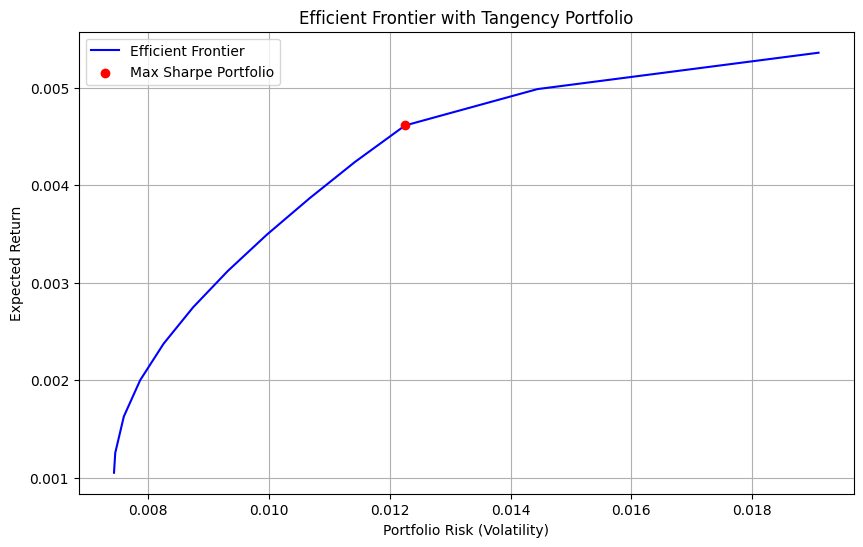

In [2]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Load Inputs ---
mu = pd.read_csv('/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/top_20_expected_returns.csv', index_col=0)['Expected_Return']
Sigma = pd.read_csv('/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/cov_matrix_actual_returns.csv', index_col=0)

mu = mu.loc[Sigma.columns]
Sigma = Sigma.loc[mu.index, mu.index]

mu_vec = mu.values
Sigma_mat = Sigma.values
n = len(mu_vec)

# --- Scan Efficient Frontier ---
target_returns = np.linspace(mu_vec.min(), mu_vec.max(), 100)
risks = []
returns = []
weights_list = []

for rt in target_returns:
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma_mat))
    max_weight = 0.10  # 10% max per stock

    constraints = [
        cp.sum(w) == 1,
        mu_vec @ w >= rt,
        w >= 0,
        w <= max_weight
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is not None:
        w_opt = w.value
        port_return = mu_vec @ w_opt
        port_risk = np.sqrt(w_opt.T @ Sigma_mat @ w_opt)
        returns.append(port_return)
        risks.append(port_risk)
        weights_list.append(w_opt)
    else:
        returns.append(np.nan)
        risks.append(np.nan)
        weights_list.append(None)

# --- Find the highest Sharpe ratio portfolio ---
returns = np.array(returns)
risks = np.array(risks)
sharpe_ratios = returns / risks
best_index = np.nanargmax(sharpe_ratios)

best_weights = weights_list[best_index]
best_return = returns[best_index]
best_risk = risks[best_index]
best_sharpe = sharpe_ratios[best_index]

# --- Output the result ---
tangency_df = pd.DataFrame({
    'Stock': mu.index,
    'Weight': best_weights
})
tangency_df = tangency_df[tangency_df['Weight'] > 0]  # filter out near-0 weights


#  Save to CSV
tangency_df.to_csv("/content/drive/My Drive/Senior Project/Correct/2nd/Markovits/mv_tangency_portfolio_weights.csv", index=False)

print("Best Sharpe Ratio Portfolio:")
print(tangency_df)
print(f"\nReturn: {best_return:.2%}")
print(f"Risk (Volatility): {best_risk:.2%}")
print(f"Sharpe Ratio: {best_sharpe:.2f}")

# --- Plot Efficient Frontier with Tangency Point ---
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label="Efficient Frontier", color='blue')
plt.scatter(best_risk, best_return, color='red', label="Max Sharpe Portfolio", zorder=5)
plt.xlabel("Portfolio Risk (Volatility)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier with Tangency Portfolio")
plt.legend()
plt.grid(True)
plt.show()

# ***MV Metrics: real data of 2024***

Backtest Results – Markowitz Tangency Portfolio (2019)
Annualized Return:     -2.92%
Annualized Volatility: 19.69%
Sharpe Ratio:          -0.15


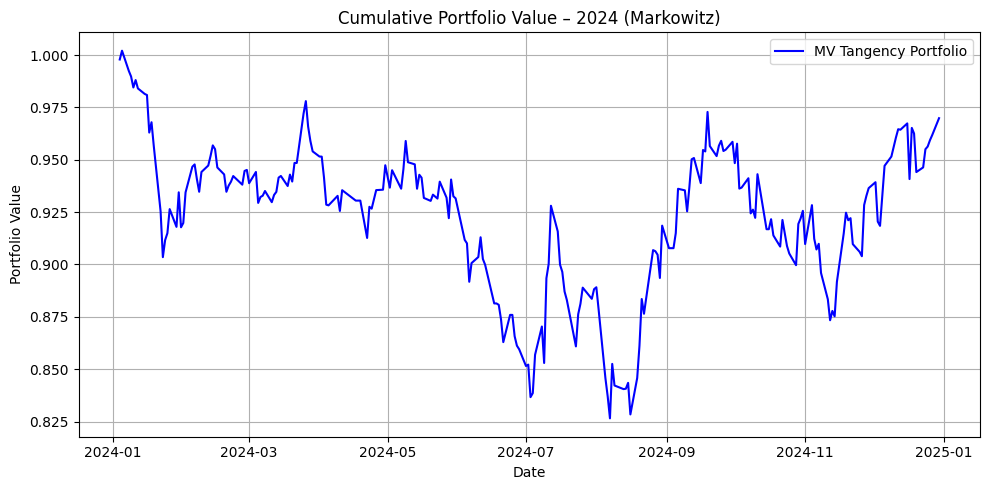

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load actual stock prices from all sheets ---
price_file = "/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/2024top20_actualPrices.xlsx"
sheet_names = pd.ExcelFile(price_file).sheet_names

price_data = {}
for sheet in sheet_names:
    df = pd.read_excel(price_file, sheet_name=sheet, index_col=0, parse_dates=True)
    if "Price" in df.columns:
        price_data[sheet] = df["Price"]
    else:
        print(f"Sheet '{sheet}' does not contain 'Price' column.")

# Combine all prices into one DataFrame
price_df = pd.concat(price_data, axis=1)
price_df.columns = sheet_names
price_df = price_df.sort_index()

# --- Step 2: Load MV Tangency Portfolio Weights ---
weights_df = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/Markovits/mv_tangency_portfolio_weights.csv")
weights_df = weights_df[weights_df['Weight'] > 1e-6]  # filter out near-zero weights

# Ensure tickers exist in price data
weights_df = weights_df[weights_df['Stock'].isin(price_df.columns)]

# Normalize weights (in case some stocks were dropped)
weights_df['Weight'] /= weights_df['Weight'].sum()

# Prepare stock list and weights
stock_list = weights_df['Stock'].tolist()
weights = weights_df['Weight'].values

# --- Step 3: Calculate Daily Returns ---
price_df = price_df[stock_list]  # filter columns to match portfolio
returns_df = price_df.pct_change().dropna()

# --- Step 4: Backtest Portfolio Performance ---
portfolio_returns = returns_df @ weights
portfolio_value = (1 + portfolio_returns).cumprod()

# Performance metrics
n_days = len(portfolio_returns)
ann_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / n_days) - 1
ann_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = ann_return / ann_volatility

# --- Step 5: Output Results ---
print("Backtest Results – Markowitz Tangency Portfolio (2019)")
print(f"Annualized Return:     {ann_return:.2%}")
print(f"Annualized Volatility: {ann_volatility:.2%}")
print(f"Sharpe Ratio:          {sharpe_ratio:.2f}")

# --- Step 6: Plot Portfolio Growth ---
plt.figure(figsize=(10, 5))
plt.plot(portfolio_value, label="MV Tangency Portfolio", color='blue')
plt.title("Cumulative Portfolio Value – 2024 (Markowitz)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

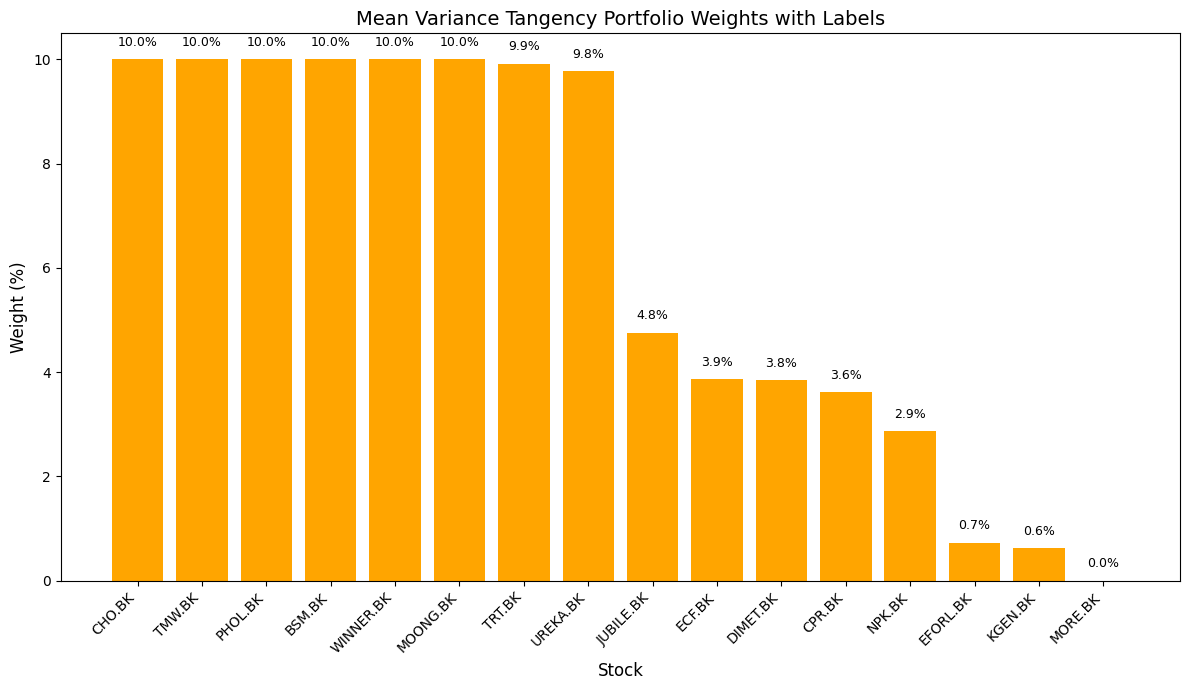

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the tangency portfolio weights CSV
file_path = '/content/drive/My Drive/Senior Project/Correct/2nd/Markovits/mv_tangency_portfolio_weights.csv'
tangency_df = pd.read_csv(file_path)

# Sort for clearer visualization
tangency_df = tangency_df.sort_values(by='Weight', ascending=False)

# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(tangency_df['Stock'], tangency_df['Weight'] * 100, color='orange')

# Add weight labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

plt.ylabel('Weight (%)', fontsize=12)
plt.xlabel('Stock', fontsize=12)
plt.title('Mean Variance Tangency Portfolio Weights with Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



---

# ***2] Equal-Weight Portfolio Evaluation (Top 20 Stocks, 2024)***

---



In [5]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
price_file = "/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/2024top20_actualPrices.xlsx"

# --- Load all sheets ---
sheets = pd.read_excel(price_file, sheet_name=None)

# --- Use the same top 20 stocks from MV (sheet names) ---
top_20_stocks = list(sheets.keys())[:20]  # or define manually if needed

# --- Compute daily log returns ---
returns_dict = {}
for stock in top_20_stocks:
    df = sheets[stock].sort_values("Date")
    df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
    returns_dict[stock] = df["Return"].dropna().values

# --- Combine into return DataFrame ---
returns_df = pd.DataFrame(returns_dict).dropna()
returns_df = returns_df[top_20_stocks]  # ensure consistent column order

# --- Equal weights ---
n = len(top_20_stocks)
equal_weights = np.array([1/n] * n)

# --- Compute portfolio returns ---
portfolio_returns = returns_df @ equal_weights

# --- Compute performance metrics ---
mean_daily = portfolio_returns.mean()
std_daily = portfolio_returns.std()
annualized_return = (1 + mean_daily)**252 - 1
annualized_volatility = std_daily * np.sqrt(252)
sharpe_ratio = mean_daily / std_daily  # assuming risk-free = 0

# --- Output results ---
print("Equal-Weight Portfolio Performance (2019):")
print(f"Annualized Return:     {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio:          {sharpe_ratio:.2f}")

Equal-Weight Portfolio Performance (2019):
Annualized Return:     -21.16%
Annualized Volatility: 21.05%
Sharpe Ratio:          -0.07


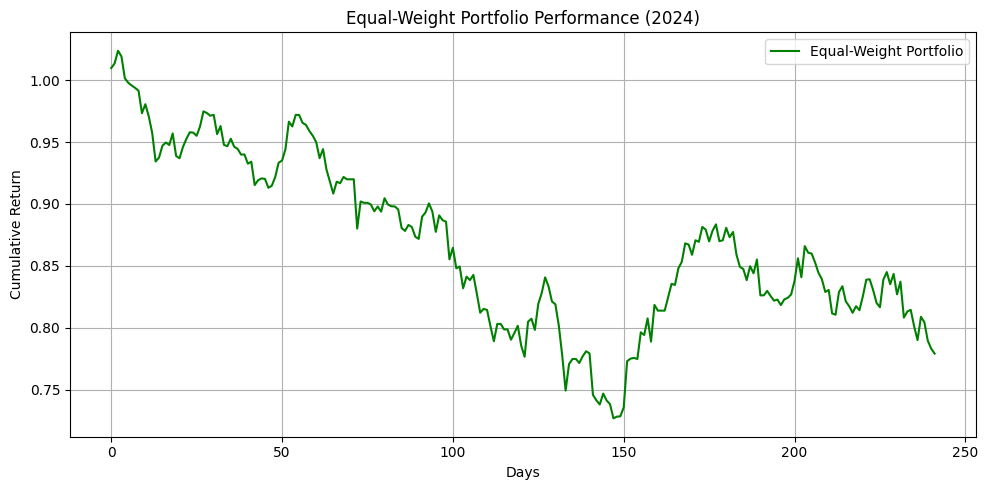

Annualized Return:     -21.16%
Annualized Volatility: 21.05%
Sharpe Ratio:          -0.07


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load actual prices file ---
price_file = "/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/2024top20_actualPrices.xlsx"
sheets = pd.read_excel(price_file, sheet_name=None)

# --- Define top 20 stocks (from your selection) ---
top_20_stocks = list(sheets.keys())[:20]

# --- Calculate daily log returns ---
returns_dict = {}
for stock in top_20_stocks:
    df = sheets[stock].sort_values("Date")
    df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
    returns_dict[stock] = df["Return"].dropna().values

returns_df = pd.DataFrame(returns_dict).dropna()
returns_df = returns_df[top_20_stocks]

# --- Equal weights ---
equal_weights = np.array([1 / len(top_20_stocks)] * len(top_20_stocks))
portfolio_returns = returns_df @ equal_weights

# --- Performance metrics ---
mean_daily = portfolio_returns.mean()
std_daily = portfolio_returns.std()
annualized_return = (1 + mean_daily) ** 252 - 1
annualized_volatility = std_daily * np.sqrt(252)
sharpe_ratio = mean_daily / std_daily  # assuming risk-free rate = 0

# --- Plot Cumulative Return over 2019 ---
cumulative_return = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_return, color='green', label='Equal-Weight Portfolio')
plt.title("Equal-Weight Portfolio Performance (2024)")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Print summary ---
print(f"Annualized Return:     {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio:          {sharpe_ratio:.2f}")

In [ ]:
ew_return = annualized_return
ew_risk = annualized_volatility

# ***Black Litterman Model***

Following Idzorek (2004), we derived the implied equilibrium returns by reverse-optimizing from the market portfolio using equal market capitalization weights and a risk aversion coefficient of λ = 3.0.
We defined τ = 0.025 and used structured investor views to construct the P and Q matrices. The posterior expected return vector was computed via the canonical Black–Litterman equation, incorporating both market equilibrium and subjective views.

1. finding Implied returns

In the Black–Litterman framework, implied returns are typically calculated using market-cap weights to reflect the market’s neutral view. However, due to unavailable historical market cap data for MAI stocks, equal weights were used instead, giving each asset an equal share in the market portfolio. This allows consistent application of the model while acknowledging that the implied returns do not reflect actual market capitalizations.

In [7]:
import pandas as pd
import numpy as np

# --- Load covariance matrix ---
cov_path ='/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/cov_matrix_actual_returns.csv'
Sigma = pd.read_csv(cov_path, index_col=0)

# --- Ensure rows/columns are aligned ---
Sigma = Sigma.loc[Sigma.columns, Sigma.columns]

# --- Set market weights (equal weight for N assets) ---
n_assets = len(Sigma)  # or len(Sigma.columns)
w_mkt = np.array([1 / n_assets] * n_assets)

# --- Set risk aversion coefficient (lambda) ---
lambda_val = 3.0  # As recommended by Idzorek's Paper

# --- Compute implied equilibrium returns (π) ---
pi = lambda_val * Sigma @ w_mkt
pi_series = pd.Series(pi, index=Sigma.columns, name="Implied_Return")

# --- Print or save result ---
print("Implied Equilibrium Returns (π):")
print(pi_series)

# --- Save π to Google Drive folder ---
output_path = "/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/implied_returns_pi.csv"
pi_series.to_csv(output_path)
print(f"Implied returns saved to: {output_path}")

Implied Equilibrium Returns (π):
CHO.BK       0.002006
MORE.BK      0.002561
TMW.BK       0.000111
UREKA.BK     0.000372
TRT.BK       0.000173
KGEN.BK      0.000841
ECF.BK       0.000468
EFORL.BK     0.000621
BSM.BK       0.000040
PHOL.BK      0.000071
DV8.BK       0.000563
CHOW.BK      0.000442
MOONG.BK     0.000069
DIMET.BK     0.000398
JUBILE.BK    0.000161
WINNER.BK    0.000049
SANKO.BK     0.000469
NPK.BK       0.000258
TNDT.BK      0.000706
CPR.BK       0.000171
Name: Implied_Return, dtype: float64
Implied returns saved to: /content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/implied_returns_pi.csv


2. Following the approach outlined by Idzorek (2005, p. 7), we constructed the Black–Litterman view matrices P and Q using predicted returns from our ANN model. The top 20 stocks were ranked by their predicted total return for 2024.
* Based on this ranking, we defined three relative views: the highest-ranked stock outperforming the lowest-ranked, the second-highest outperforming the second-lowest, and the highest outperforming the second-lowest.
* The P matrix captures these views structurally by assigning +1 to the long position and −1 to the short position. The Q vector contains the predicted return differences for each view. These matrices serve as inputs for computing the Black–Litterman posterior expected returns \mu_{BL}.

In [8]:
import pandas as pd

# --- Load expected returns file (already sorted top 20 from ANN) ---
file_path = "/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/top_20_expected_returns.csv"
expected_df = pd.read_csv(file_path, index_col=0)

# --- Sort from highest to lowest return ---
expected_df = expected_df.sort_values(by="Expected_Return", ascending=False)

# --- Get top 2 and bottom 2 stocks ---
top_stocks = expected_df.head(2)
bottom_stocks = expected_df.tail(2)

# --- Build list of all 20 stocks for reference ---
stock_list = list(expected_df.index)
n = len(stock_list)

# --- Define 3 views using strongest relative comparisons ---
views = [
    (top_stocks.index[0], bottom_stocks.index[-1]),  # View 1
    (top_stocks.index[1], bottom_stocks.index[-2]),  # View 2
    (top_stocks.index[0], bottom_stocks.index[-2])   # View 3
]

# --- Construct P and Q ---
P = []
Q = []

for long_stock, short_stock in views:
    p_row = [0] * n
    i = stock_list.index(long_stock)
    j = stock_list.index(short_stock)
    p_row[i] = 1
    p_row[j] = -1
    P.append(p_row)

    q_val = expected_df.loc[long_stock, "Expected_Return"] - expected_df.loc[short_stock, "Expected_Return"]
    Q.append(q_val)

# --- Convert to DataFrames ---
P_df = pd.DataFrame(P, columns=stock_list)
Q_df = pd.DataFrame(Q, columns=["Q"])
Q_df.index = [f"View{i+1}" for i in range(len(Q))]

# --- Display top/bottom stocks used for reference ---
print("Top 2 Predicted Stocks:\n", top_stocks)
print("\nBottom 2 Predicted Stocks:\n", bottom_stocks)

# --- Save results to Drive ---
P_df.to_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_matrix_P.csv", index=False)
Q_df.to_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_values_Q.csv")

print("\nP and Q matrices saved to Google Drive.")

Top 2 Predicted Stocks:
          Expected_Return
CHO.BK          0.036689
MORE.BK         0.004949

Bottom 2 Predicted Stocks:
          Expected_Return
TNDT.BK        -0.000179
CPR.BK         -0.000236

P and Q matrices saved to Google Drive.


3. Following Idzorek (2005, p. 8), the confidence matrix \Omega represents the investor’s uncertainty regarding their views. Each diagonal element of \Omega quantifies the variance (risk) associated with a specific view.

*	\tau is a scalar used to scale the uncertainty in the market equilibrium (commonly \tau = 0.05)

In [9]:
# --- Load inputs ---
Sigma = pd.read_csv('/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/cov_matrix_actual_returns.csv', index_col =0)
P = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_matrix_P.csv")
tau = 0.05

# --- Ensure columns of Σ match the stock order in P ---
Sigma = Sigma.loc[P.columns, P.columns]  # reorders Sigma to match P

# --- Compute Omega using Idzorek's method ---
Sigma_np = Sigma.values
P_np = P.values

Omega = np.diag(np.diag(tau * P_np @ Sigma_np @ P_np.T)) * 100

# --- Save to DataFrame and optionally export ---
Omega_df = pd.DataFrame(Omega, index=[f"View{i+1}" for i in range(Omega.shape[0])],
                        columns=[f"View{i+1}" for i in range(Omega.shape[1])])

Omega_df.to_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_confidence_Omega.csv")

print("Confidence Matrix (Ω) saved to Google Drive.")

Confidence Matrix (Ω) saved to Google Drive.


4. Final: Using the formulation from Idzorek (2005, p. 9), we computed the posterior expected return vector \mu by combining the implied equilibrium returns \pi with the investor’s views (P, Q) and confidence (Ω). This adjusted return vector reflects a Bayesian blend of market consensus and our predictive insights, and is used as input to the final portfolio optimization.


In [10]:
# --- Load required inputs from previous steps ---
Sigma = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/cov_matrix_actual_returns.csv", index_col=0)
P = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_matrix_P.csv")
Q_raw = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_values_Q.csv")
Omega = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/view_confidence_Omega.csv", index_col=0)
pi = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/implied_returns_pi.csv", index_col=0)

## Fix Q matrix: get only the numeric Q column (not the first column)
Q = Q_raw.iloc[:, 1].values.reshape(-1, 1)

# Align all to the same stock order
Sigma = Sigma.loc[P.columns, P.columns]
pi = pi.loc[P.columns]

# Convert to NumPy arrays
tau = 0.05
Sigma_np = Sigma.values
P_np = P.values
pi_np = pi.values.reshape(-1, 1)
Omega_np = Omega.values

# Black–Litterman calculations using pseudo-inverse
tau_Sigma_inv = np.linalg.pinv(tau * Sigma_np)  # ← safe replacement
Omega_inv = np.linalg.inv(Omega_np)

middle_term = np.linalg.inv(tau_Sigma_inv + P_np.T @ Omega_inv @ P_np)
right_term = (tau_Sigma_inv @ pi_np) + (P_np.T @ Omega_inv @ Q)

mu_BL = middle_term @ right_term

# Save results
mu_BL_series = pd.Series(mu_BL.flatten(), index=P.columns, name="BL_Expected_Return")
mu_BL_series.to_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/black_litterman_expected_returns.csv")

print("✅ Posterior expected returns (μ_BL) saved successfully.")

✅ Posterior expected returns (μ_BL) saved successfully.


The covariance matrix became near-singular due to high correlations in the dataset. New dataset (2019–2023) may have stocks that moved almost identically during certain periods. Using the pseudo-inverse ensures numerical stability while maintaining the structure of the Black–Litterman model, which is a common and acceptable practice in portfolio optimization.

# ***Final Step: Portfolio Optimization Using (μ_BL)***


# ***Using Efficeint Frontier***

Black–Litterman Max Sharpe Ratio Portfolio:
        Stock    Weight
0      CHO.BK  0.068786
1     MORE.BK  0.049644
2      TMW.BK  0.050261
3    UREKA.BK  0.049136
4      TRT.BK  0.049508
5     KGEN.BK  0.048706
6      ECF.BK  0.048749
7    EFORL.BK  0.049143
8      BSM.BK  0.050185
9     PHOL.BK  0.055879
10     DV8.BK  0.049429
11    CHOW.BK  0.049116
12   MOONG.BK  0.052364
13   DIMET.BK  0.049255
14  JUBILE.BK  0.050777
15  WINNER.BK  0.053416
16   SANKO.BK  0.048988
17     NPK.BK  0.048646
18    TNDT.BK  0.038512
19     CPR.BK  0.039501

Return: 0.06%
Risk (Volatility): 1.40%
Sharpe Ratio: 0.04


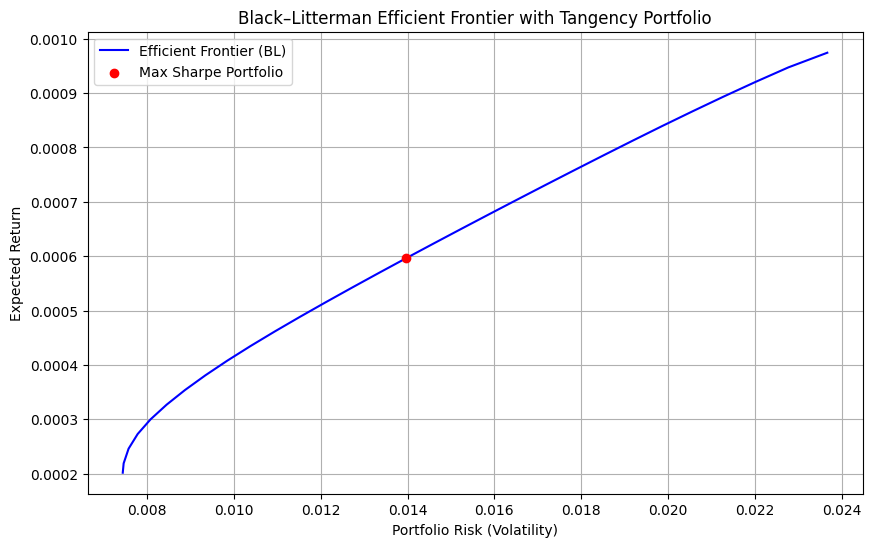

In [11]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Step 1: Load Inputs ---
mu = pd.read_csv('/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/black_litterman_expected_returns.csv', index_col=0)['BL_Expected_Return']
Sigma = pd.read_csv('/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/cov_matrix_actual_returns.csv', index_col=0)

# --- Step 2: Ensure alignment ---
mu = mu.loc[Sigma.columns]
Sigma = Sigma.loc[mu.index, mu.index]

mu_vec = mu.values
Sigma_mat = Sigma.values
n = len(mu_vec)

# --- Step 3: Scan Efficient Frontier ---
target_returns = np.linspace(mu_vec.min(), mu_vec.max(), 100)
risks = []
returns = []
weights_list = []
max_weight = 0.10  # Maximum 10% allocation per stock

for rt in target_returns:
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma_mat))
    constraints = [
        cp.sum(w) == 1,
        mu_vec @ w >= rt,
        w >= 0,
        w <= max_weight
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is not None:
        w_opt = w.value
        port_return = mu_vec @ w_opt
        port_risk = np.sqrt(w_opt.T @ Sigma_mat @ w_opt)
        returns.append(port_return)
        risks.append(port_risk)
        weights_list.append(w_opt)
    else:
        returns.append(np.nan)
        risks.append(np.nan)
        weights_list.append(None)

# --- Step 4: Identify Max Sharpe Portfolio ---
returns = np.array(returns)
risks = np.array(risks)
sharpe_ratios = returns / risks
best_index = np.nanargmax(sharpe_ratios)

best_weights = weights_list[best_index]
best_return = returns[best_index]
best_risk = risks[best_index]
best_sharpe = sharpe_ratios[best_index]

# --- Step 5: Save and Output ---
tangency_df = pd.DataFrame({
    'Stock': mu.index,
    'Weight': best_weights
})
tangency_df = tangency_df[tangency_df['Weight'] > 0]  # filter out zero weights

# Save tangency weights
tangency_df.to_csv('/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/bl_tangency_portfolio_weights.csv', index=False)

# --- Output to console ---
print("Black–Litterman Max Sharpe Ratio Portfolio:")
print(tangency_df)
print(f"\nReturn: {best_return:.2%}")
print(f"Risk (Volatility): {best_risk:.2%}")
print(f"Sharpe Ratio: {best_sharpe:.2f}")

# --- Step 6: Plot Efficient Frontier ---
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label="Efficient Frontier (BL)", color='blue')
plt.scatter(best_risk, best_return, color='red', label="Max Sharpe Portfolio", zorder=5)
plt.xlabel("Portfolio Risk (Volatility)")
plt.ylabel("Expected Return")
plt.title("Black–Litterman Efficient Frontier with Tangency Portfolio")
plt.legend()
plt.grid(True)
plt.show()

# **Back Test with actual 2024 data**

📊 Backtest Results – Black–Litterman Portfolio (2024)
Annualized Return: -1.96%
Annualized Volatility: 22.47%
Sharpe Ratio: -0.09


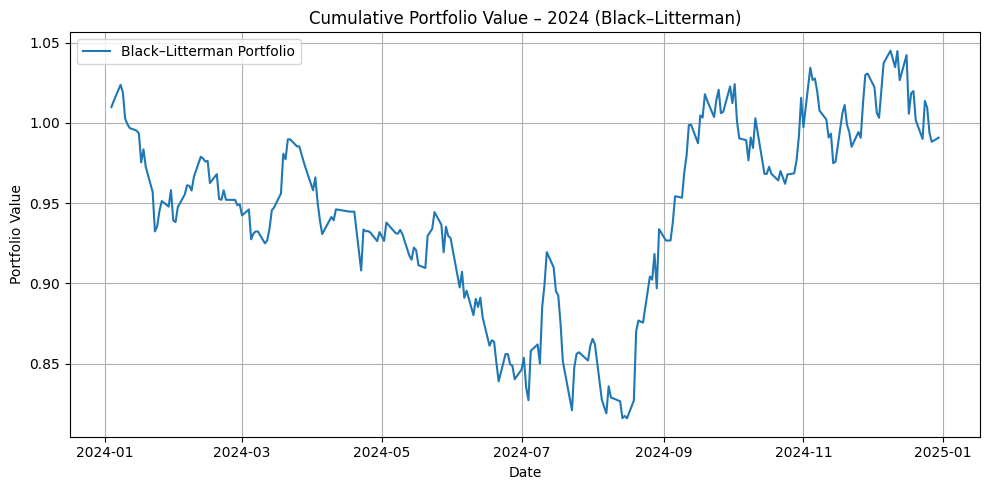

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Black–Litterman weights ---
bl_weights_df = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/bl_tangency_portfolio_weights.csv")
bl_weights_df = bl_weights_df[bl_weights_df['Weight'] > 1e-6]  # remove near-zero weights

bl_stock_list = bl_weights_df['Stock'].tolist()
bl_weights = bl_weights_df['Weight'].values

# --- Load actual price data from Excel sheets ---
file_path = "/content/drive/My Drive/Senior Project/Correct/2nd/Input_for_models/2024top20_actualPrices.xlsx"
sheet_names = pd.ExcelFile(file_path).sheet_names

# Read and combine price data
price_data = {}
for sheet in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet, index_col=0, parse_dates=True)
    if "Price" in df.columns:
        price_data[sheet] = df["Price"]

price_df = pd.concat(price_data, axis=1)
price_df.columns = sheet_names
price_df = price_df.sort_index()

# --- Match order of stocks ---
price_df = price_df[bl_stock_list]

# --- Calculate returns ---
returns_df = price_df.pct_change().dropna()

# --- Compute portfolio returns ---
portfolio_returns = returns_df @ bl_weights
portfolio_value = (1 + portfolio_returns).cumprod()

# --- Compute performance metrics ---
n_days = len(portfolio_returns)
ann_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0])**(252 / n_days) - 1
ann_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = ann_return / ann_volatility

# --- Print results ---
print("📊 Backtest Results – Black–Litterman Portfolio (2024)")
print(f"Annualized Return: {ann_return:.2%}")
print(f"Annualized Volatility: {ann_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# --- Plot cumulative portfolio value ---
plt.figure(figsize=(10, 5))
plt.plot(portfolio_value, label="Black–Litterman Portfolio")
plt.title("Cumulative Portfolio Value – 2024 (Black–Litterman)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

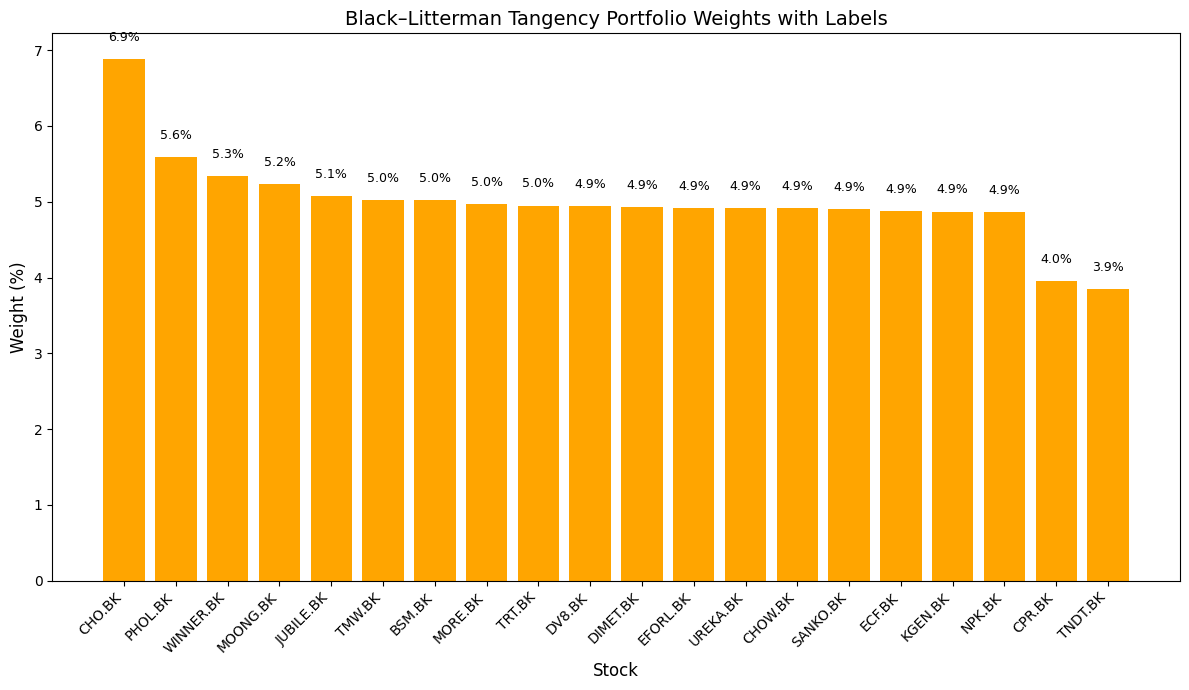

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the tangency portfolio weights CSV
file_path = '/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/bl_tangency_portfolio_weights.csv'
tangency_df = pd.read_csv(file_path)

# Sort for clearer visualization
tangency_df = tangency_df.sort_values(by='Weight', ascending=False)

# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(tangency_df['Stock'], tangency_df['Weight'] * 100, color='orange')

# Add weight labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

plt.ylabel('Weight (%)', fontsize=12)
plt.xlabel('Stock', fontsize=12)
plt.title('Black–Litterman Tangency Portfolio Weights with Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

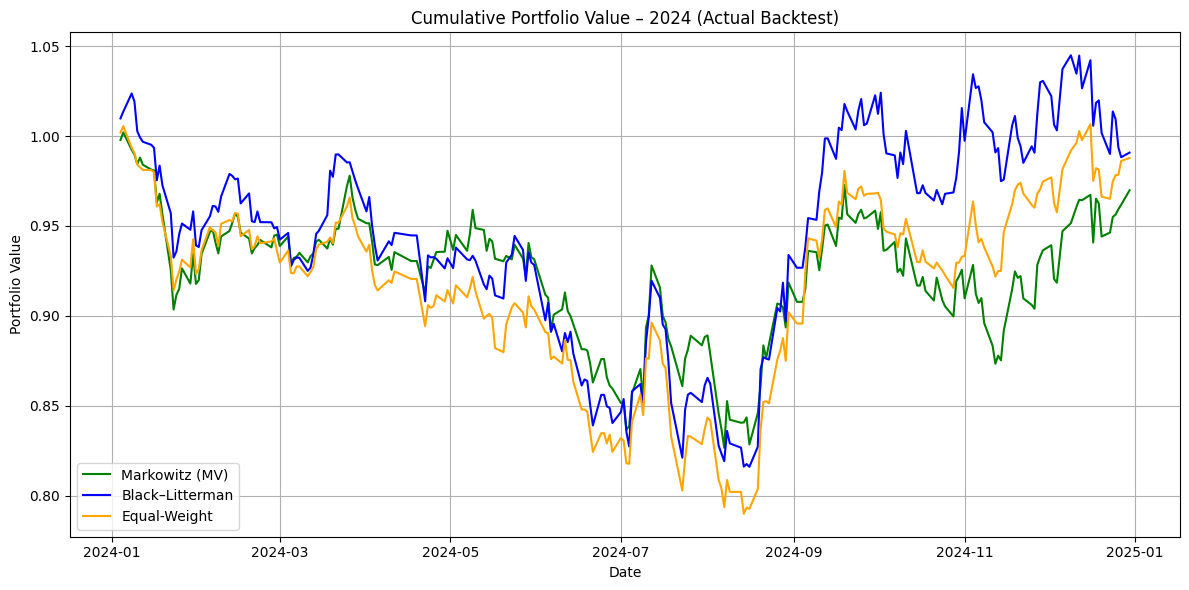

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load MV Tangency Weights ---
mv_df = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/Markovits/mv_tangency_portfolio_weights.csv")
mv_df = mv_df[mv_df['Weight'] > 1e-6]
mv_df = mv_df[mv_df['Stock'].isin(price_df.columns)]
mv_df['Weight'] /= mv_df['Weight'].sum()

# --- Load BL Tangency Weights ---
bl_df = pd.read_csv("/content/drive/My Drive/Senior Project/Correct/2nd/BlackLitterman/bl_tangency_portfolio_weights.csv")
bl_df = bl_df[bl_df['Weight'] > 1e-6]
bl_df = bl_df[bl_df['Stock'].isin(price_df.columns)]
bl_df['Weight'] /= bl_df['Weight'].sum()

# --- Equal Weight for Common Stocks ---
common_stocks = list(set(mv_df['Stock']) & set(bl_df['Stock']))
ew_weights = np.array([1/len(common_stocks)] * len(common_stocks))

# --- Align Price Data ---
mv_prices = price_df[mv_df['Stock'].tolist()]
bl_prices = price_df[bl_df['Stock'].tolist()]
ew_prices = price_df[common_stocks]

# --- Compute Daily Returns ---
mv_returns = mv_prices.pct_change().dropna()
bl_returns = bl_prices.pct_change().dropna()
ew_returns = ew_prices.pct_change().dropna()

# --- Compute Portfolio Cumulative Values ---
mv_cum = (1 + mv_returns @ mv_df['Weight'].values).cumprod()
bl_cum = (1 + bl_returns @ bl_df['Weight'].values).cumprod()
ew_cum = (1 + ew_returns @ ew_weights).cumprod()

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(mv_cum, label="Markowitz (MV)", color='green')
plt.plot(bl_cum, label="Black–Litterman", color='blue')
plt.plot(ew_cum, label="Equal-Weight", color='orange')
plt.title("Cumulative Portfolio Value – 2024 (Actual Backtest)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()